In [ ]:
!pip install sacremoses datasets

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "allegro/herbert-base-cased"
NUM_LABELS = 3

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

### ***wczytanie danych***

In [ ]:
import pandas as pd
from datasets import Dataset
try:
    from google.colab import drive
    drive.mount('/content/drive')
    TRAIN_DATA_PATH = '/content/drive/MyDrive/PWr/NLP/data/train.csv'
    TEST_DATA_PATH = '/content/drive/MyDrive/PWr/NLP/data/test.csv'
except (ImportError, ModuleNotFoundError):
    # If not running in Colab, use local paths
    TRAIN_DATA_PATH = '../data/processed/train.csv'
    TEST_DATA_PATH = '../data/processed/test.csv'



train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
train_df["labels"] = train_df["label"]
test_df["labels"] = test_df["label"]

# delete the old column
train_df.drop(columns=["label"], inplace=True)
test_df.drop(columns=["label"], inplace=True)

train_split = Dataset.from_pandas(train_df)
test_split = Dataset.from_pandas(test_df)


def tokenize_function(examples, max_length=512):
    tokenized_inputs = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None  # Return as lists rather than tensors
    )

    # Add labels to tokenized output
    tokenized_inputs['labels'] = examples['labels']

    return tokenized_inputs

train_dataset = train_split.map(tokenize_function, batched=True)
eval_dataset = test_split.map(tokenize_function, batched=True)

# distribution of labels
train_df['labels'].value_counts()

In [5]:
from torch.utils.data import DataLoader

train_dataset.set_format('torch')
eval_dataset.set_format('torch')

train_dataloader = DataLoader(train_dataset, batch_size=16)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)

### ustawienie adapterów ***peft***

In [6]:
eval_dataset

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 28
})

In [7]:
# !pip install peft

In [8]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,  # Rank of the adapter matrix
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate
    target_modules=["query", "value"],  # Target modules to apply LoRA (attention layers)
    task_type="SEQUENCE_CLASSIFICATION"
)

# Wrap the model with PEFT adapters
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 294,912 || all params: 124,740,099 || trainable%: 0.2364


In [9]:
seq_cls_model = peft_model.merge_and_unload()

for n, param in seq_cls_model.named_parameters():

    if 'classifier' in n or "lora" in n:
        param.requires_grad = True
    else:
        param.requires_grad = False

### ***stroimy!***

In [10]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

In [11]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    predicted_labels = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predicted_labels, average="weighted")
    accuracy = accuracy_score(labels, predicted_labels)
    return {"f1": f1, "accuracy": accuracy}

In [12]:
NUM_EPOCHS = 50
BATCH_SIZE = 16

train_args = TrainingArguments(
    output_dir="bert-lora-seq",
    learning_rate=1e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    warmup_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none"
)


trainer = Trainer(
    model=seq_cls_model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

<ipython-input-12-ca0873f166be>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
trainer.evaluate()

{'eval_loss': 1.0951786041259766,
 'eval_model_preparation_time': 0.0031,
 'eval_f1': 0.2945269016697588,
 'eval_accuracy': 0.39285714285714285,
 'eval_runtime': 1.6849,
 'eval_samples_per_second': 16.618,
 'eval_steps_per_second': 1.187}

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Accuracy
1,1.090100,1.094799,0.003100,0.294527,0.392857
2,1.095800,1.094405,0.003100,0.294527,0.392857
3,1.092200,1.094194,0.003100,0.294527,0.392857
4,1.093400,1.092068,0.003100,0.294527,0.392857
5,1.104200,1.090885,0.003100,0.206206,0.321429
6,1.092500,1.090276,0.003100,0.257885,0.357143
7,1.094500,1.088807,0.003100,0.255184,0.357143
8,1.084100,1.086820,0.003100,0.255184,0.357143
9,1.087300,1.086194,0.003100,0.255184,0.357143
10,1.090000,1.086845,0.003100,0.255952,0.357143


TrainOutput(global_step=350, training_loss=1.0670043536594935, metrics={'train_runtime': 387.9671, 'train_samples_per_second': 14.176, 'train_steps_per_second': 0.902, 'total_flos': 1447123797504000.0, 'train_loss': 1.0670043536594935, 'epoch': 50.0})

In [15]:
trainer.evaluate()

{'eval_loss': 1.0679081678390503,
 'eval_model_preparation_time': 0.0031,
 'eval_f1': 0.47488226059654626,
 'eval_accuracy': 0.5,
 'eval_runtime': 0.9678,
 'eval_samples_per_second': 28.932,
 'eval_steps_per_second': 2.067,
 'epoch': 50.0}

In [3]:
eval_results = {'eval_loss': 1.0679081678390503,
 'eval_model_preparation_time': 0.0031,
 'eval_f1': 0.47488226059654626,
 'eval_accuracy': 0.5,
 'eval_runtime': 0.9678,
 'eval_samples_per_second': 28.932,
 'eval_steps_per_second': 2.067,
 'epoch': 50.0}

print("Evaluation Results:")
print("-" * 50)
print(f"Loss:                     {eval_results['eval_loss']:.4f}")
print(f"Model Preparation Time:   {eval_results['eval_model_preparation_time']:.4f} s")
print(f"F1 Score:                 {eval_results['eval_f1']:.4f}")
print(f"Accuracy:                 {eval_results['eval_accuracy']:.4f}")
print(f"Runtime:                  {eval_results['eval_runtime']:.4f} s")
print(f"Samples per Second:       {eval_results['eval_samples_per_second']:.2f}")
print(f"Steps per Second:         {eval_results['eval_steps_per_second']:.3f}")
if 'epoch' in eval_results:
    print(f"Epochs:                   {eval_results['epoch']:.0f}")
print("-" * 50)

Evaluation Results:
--------------------------------------------------
Loss:                     1.0679
Model Preparation Time:   0.0031 s
F1 Score:                 0.4749
Accuracy:                 0.5000
Runtime:                  0.9678 s
Samples per Second:       28.93
Steps per Second:         2.067
Epochs:                   50
--------------------------------------------------


In [16]:
predictions = trainer.predict(eval_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

results_df = pd.DataFrame({
    'text': test_df['text'],
    'true_label': test_df['labels'],
    'predicted_label': predicted_labels
})

# Display some examples
num_examples_to_display = 10  # Adjust this number as needed

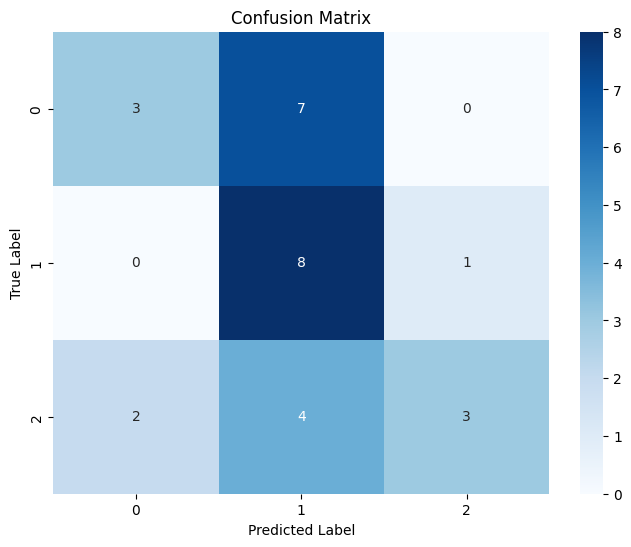

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'results_df' is your DataFrame with 'true_label' and 'predicted_label' columns
cm = confusion_matrix(results_df['true_label'], results_df['predicted_label'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from IPython.display import display, HTML

def display_results(df):
  html = """
  <style>
    table {
      border-collapse: collapse;
      width: 100%;
    }

    th, td {
      border: 1px solid black;
      padding: 8px;
      text-align: left;
    }

    th {
      background-color: #f2f2f2;
    }

    .text-column {
      width: 60%;
      word-wrap: break-word;
    }

    .narrow-column {
      width: 10%;
    }
  </style>
  <table>
    <thead>
      <tr>
        <th class="text-column">Text</th>
        <th>True Label</th>
        <th class="narrow-column">Predicted Label</th>
      </tr>
    </thead>
    <tbody>
  """

  for index, row in df.iterrows():
    html += f"""
      <tr>
        <td class="text-column">{row['text']}</td>
        <td>{row['true_label']}</td>
        <td class="narrow-column">{row['predicted_label']}</td>
      </tr>
    """

  html += """
    </tbody>
  </table>
  """

  display(HTML(html))


display_results(results_df[:10])

Text,True Label,Predicted Label
"Produkt posiada wszystkie wcięcia które powinien posiadać, lecz nie wszystkie kable da się podłączyć do lądowania (dolną część ramki przy gnieździe do ładowania trzeba nadpiłować). Poza tym ramka godna polecenia. Nie odpina się, spadł telefon mi nie raz i nadal żyje (nie korzystam ze szkła hartowanego). Lepsze rozwiązanie niż z podobnymi ramkami przykręcanymi na śrubki które wiecznie się odkręcają.",1,1
"Po niecałym dniu użytkowania szkło zaczęło się kruszyć i pękać, mimo że telefon był w obudowie i tak na prawdę nie uległ żadnemu upadkowi, ani niczemu co mogło wpłynąć na jego uszkodzenie. Mam też wrażenie, że nieco wpływa na jakość przedniego aparatu, ponieważ czasami obraz jest zamglony. Dopasowanie jest jednak bardzo dobre i sam klej dobrze trzyma.",0,0
"ciężko podważyć ich oryginalność, na co dostałem zapewnienie, bo wyglądają identycznie jak te dołączone do Samsunga S8 za 2500zł, które miałem okazję testować od znajomego (dlatego się połasiłem) Niemniej grają o wiele słabiej. Mają zdecydowanie mniej dołu, są cichsze, dźwięk jest mniej nasycony. Reasumując sugeruję testować je na miejscu i wtedy podejmować decyzję w celu uniknięcia rozczarowania. pozdrawiam.",0,0
"Moja stara N72 padła po 8 latach użytkowania. Nikt nie chciał podjąć się naprawy. Kupiłem ten sam model ze względu na bezawaryjność, przyciski (sic!) i sentyment. Choć również jestem użytkownikiem smartfona, to preferuję telefony z klawiaturą, zwłaszcza, gdy korzystam z urządzenia na mrozie czy deszczu. Nokia E72 nigdy mnie nie zawiodła.",1,1
"Sprzedającego ten produkt omijać z daleka. Sprzęt nie zgodny z tym co jest wystawione na aukcji,czyli starszy model. Widoczne były ślady użytkowania. Nie podłączyłem tych słuchawek bo nie był to ten model co widniał na aukcji. Reklamacja i zwrot odbyła się bez problemów z jedną małą rzeczą.. Nie mogłem odesłać w pakiecie Smart.",0,1
"Urządzenie kupione w celu użytkowania, jako budzik doskonale widoczny w nocy. Spełnia swą rolę doskonale, jednakże ekran dotykowy oraz menu ustawień jest niskiej jakości. To samo dotyczy wyboru wyświetlania czasu - po prostu nie ma go. Zdaję sobie sprawę, że jest to urządzenie mające służyć zupełnie innym celom, ale lepszą decyzją byłby tablet...",1,1
"Bardzo kiepskie wykonanie nie polecam zakupu. Klej naniesiony nie trzyma, dotyk źle wykrojony nie przylega do ramki w rogach, otwór na przycisk home zbyt wielki w konsekwencji przycisk lata na boki, trzeba się zaopatrzyć w klej B-7000, szkło nie dolane z wadą na środku w konsekwencji wielki bombel i o wiele za wąski od razu poszedł do kosza",0,1
"spełnia swoje zadanie, ale poprzedni model który miałem miał metalowy spód a tu plastik, nie otwiera się bezszelestnie tylko na sucho trochę szoruje (przydałoby się jakieś smarowanie), wydaje sygnał dźwiękowy otwierając się z kilko sek. opóźnieniem, to też w porównaniu do mojej oryginalnej z laptopa trochę dziwne, dioda świeci na żółto, a w starej miałem na pomarańczowo",1,1
Kamera działa ok ale radio to porażka. Guziki na przodzie to atrapa. Gdyby mi gdzieś pokrętło nie wyleciało bo nawet nie było przyklejone to bym odesłał. Gubi dźwięk i raz gra raz nie. Nawet żeby ściszyć to trzeba sie rozkojarzyć bo pokrętło na panelu nie działa. Nie tracie nerwów na te chińskie badziewia. Lepiej dołożyć i mieć spokój.,0,1
"Do Bosch SMV53L10EU pasuje IDEALNIE - wpasowuje się w nowe miejsce (które jest przygotowane w zmywarce), więc jeśli po drodze coś się połamało w gnieździe to bez obaw - wchodzi idealnie. Zastosowano łączenie bardziej trwałe niż w oryginalnej zmywarce. Wszystko na koniec trzeba delikatnie potraktować młotkiem, żeby schowało się pod osłonkę - każdy sobie z tym poradzi ;-)",2,0


## **GPT-2**

In [ ]:
!pip install peft

In [ ]:
import torch
from transformers import (AutoModelForSequenceClassification,
                          AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding)
from peft import LoraConfig, get_peft_model, TaskType


MODEL_NAME = "gpt2"
NUM_LABELS = 3

gpt_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token  # Set pad token to EOS token
gpt_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
gpt_model.config.pad_token_id = gpt_tokenizer.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd
from datasets import Dataset
try:
    from google.colab import drive
    drive.mount('/content/drive')
    TRAIN_DATA_PATH = '/content/drive/MyDrive/PWr/NLP/data/train.csv'
    TEST_DATA_PATH = '/content/drive/MyDrive/PWr/NLP/data/test.csv'
except (ImportError, ModuleNotFoundError):
    # If not running in Colab, use local paths
    TRAIN_DATA_PATH = '../data/processed/train.csv'
    TEST_DATA_PATH = '../data/processed/test.csv'



train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
train_df["labels"] = train_df["label"]
test_df["labels"] = test_df["label"]

# delete the old column
train_df.drop(columns=["label"], inplace=True)
test_df.drop(columns=["label"], inplace=True)

train_split = Dataset.from_pandas(train_df)
test_split = Dataset.from_pandas(test_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def tokenize_function(examples, max_length=1024):
    # GPT2 tokenizer needs special handling for padding token
    gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

    tokenized_inputs = gpt_tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None  # Return as lists rather than tensors
    )

    # Add labels to tokenized output
    tokenized_inputs['labels'] = examples['labels']

    return tokenized_inputs

# Apply tokenization to both datasets
train_dataset = train_split.map(tokenize_function, batched=True, remove_columns=train_split.column_names)
eval_dataset = test_split.map(tokenize_function, batched=True, remove_columns=test_split.column_names)

train_dataset.set_format('torch')
eval_dataset.set_format('torch')
train_dataset

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 110
})

In [ ]:
gpt_model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    predicted_labels = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predicted_labels, average="weighted")
    accuracy = accuracy_score(labels, predicted_labels)
    return {"f1": f1, "accuracy": accuracy}

### ***classification-head only***

In [ ]:
gpt_model.requires_grad_(False)

for name, param in gpt_model.named_parameters():
    if "lora" in name or "score" in name:  # LoRA and classification head
        param.requires_grad = True

# Confirm trainable parameters
for name, param in gpt_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.requires_grad}")

score.weight: True


In [ ]:
NUM_EPOCHS = 30
BATCH_SIZE = 16  # Reduced batch size to 1 to avoid padding issues

# Training Arguments
train_args = TrainingArguments(
    output_dir="gpt2-cls-head-only",
    learning_rate=5e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    warmup_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    # load_best_model_at_end=True,
    # metric_for_best_model="f1",
    # greater_is_better=True
)

# Trainer
trainer = Trainer(
    model=gpt_model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=gpt_tokenizer),
    compute_metrics=compute_metrics,
)

trainer.evaluate()

{'eval_loss': 1.050960659980774,
 'eval_model_preparation_time': 0.0045,
 'eval_f1': 0.38644688644688646,
 'eval_accuracy': 0.42857142857142855,
 'eval_runtime': 1.9942,
 'eval_samples_per_second': 14.04,
 'eval_steps_per_second': 1.003}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Accuracy
1,0.978400,1.049715,0.004500,0.386447,0.428571
2,0.975300,1.055886,0.004500,0.391457,0.428571
3,0.904500,1.064940,0.004500,0.357993,0.392857
4,0.988600,1.053101,0.004500,0.391457,0.428571
5,0.958100,1.043286,0.004500,0.447317,0.464286
6,0.951700,1.044172,0.004500,0.386447,0.428571
7,0.942000,1.032919,0.004500,0.465861,0.464286
8,0.945100,1.040114,0.004500,0.391457,0.428571
9,0.933100,1.053852,0.004500,0.357993,0.392857
10,0.918500,1.068314,0.004500,0.391457,0.428571


TrainOutput(global_step=210, training_loss=0.8777019591558547, metrics={'train_runtime': 742.8936, 'train_samples_per_second': 4.442, 'train_steps_per_second': 0.283, 'total_flos': 1724574125260800.0, 'train_loss': 0.8777019591558547, 'epoch': 30.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.959460437297821,
 'eval_model_preparation_time': 0.0045,
 'eval_f1': 0.5280612244897959,
 'eval_accuracy': 0.5357142857142857,
 'eval_runtime': 1.9774,
 'eval_samples_per_second': 14.16,
 'eval_steps_per_second': 1.011,
 'epoch': 30.0}

In [ ]:
trainer.model.save_pretrained('content/drive/My Drive/PWr/NLP/models/gpt2-cls-head.pth')

### ***LoRA***

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Task type: Sequence Classification
    r=8,                        # Rank of LoRA matrices
    lora_alpha=16,              # Scaling factor
    target_modules=["c_proj"],  # GPT-2 target modules for LoRA
    lora_dropout=0.1,           # Dropout rate
    bias="none",                # No additional biases
)

# Wrap model with LoRA
lora_model = get_peft_model(gpt_model, lora_config)

# Freeze all base model parameters
for param in gpt_model.parameters():
    param.requires_grad = False

# Train only LoRA layers and the classification head
for name, param in lora_model.named_parameters():
    if "lora" in name or "score" in name:  # LoRA and classification head
        param.requires_grad = True

# Confirm trainable parameters
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.requires_grad}")

base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight: True
base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight: True
base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight: True
base_model.model.transformer.h.0.mlp.c_proj.lora_B.default.weight: True
base_model.model.transformer.h.1.attn.c_proj.lora_A.default.weight: True
base_model.model.transformer.h.1.attn.c_proj.lora_B.default.weight: True
base_model.model.transformer.h.1.mlp.c_proj.lora_A.default.weight: True
base_model.model.transformer.h.1.mlp.c_proj.lora_B.default.weight: True
base_model.model.transformer.h.2.attn.c_proj.lora_A.default.weight: True
base_model.model.transformer.h.2.attn.c_proj.lora_B.default.weight: True
base_model.model.transformer.h.2.mlp.c_proj.lora_A.default.weight: True
base_model.model.transformer.h.2.mlp.c_proj.lora_B.default.weight: True
base_model.model.transformer.h.3.attn.c_proj.lora_A.default.weight: True
base_model.model.transformer.h.3.attn.c_proj.lora_B.defau

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
def tokenize_function(examples, max_length=512):
    # GPT2 tokenizer needs special handling for padding token
    gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

    tokenized_inputs = gpt_tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None  # Return as lists rather than tensors
    )

    # Add labels to tokenized output
    tokenized_inputs['labels'] = examples['labels']

    return tokenized_inputs

train_dataset = train_split.map(tokenize_function, batched=True, remove_columns=train_split.column_names)
eval_dataset = test_split.map(tokenize_function, batched=True, remove_columns=test_split.column_names)

train_dataset.set_format('torch')
eval_dataset.set_format('torch')

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
NUM_EPOCHS = 50
BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 2

# Training Arguments
train_args = TrainingArguments(
    output_dir="'content/drive/MyDrive/PWr/NLP/models/",
    learning_rate=1e-4,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    warmup_steps=120,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

# Trainer
trainer = Trainer(
    model=lora_model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=gpt_tokenizer),
    compute_metrics=compute_metrics,
)

trainer.evaluate()

{'eval_loss': 1.2906720638275146,
 'eval_model_preparation_time': 0.008,
 'eval_f1': 0.3523365868086365,
 'eval_accuracy': 0.39285714285714285,
 'eval_runtime': 1.0609,
 'eval_samples_per_second': 26.393,
 'eval_steps_per_second': 3.77}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Accuracy
1,1.226800,1.286732,0.008000,0.352337,0.392857
2,1.199800,1.277846,0.008000,0.352337,0.392857
3,1.159500,1.264330,0.008000,0.322511,0.357143
4,1.217600,1.247573,0.008000,0.289881,0.321429
5,1.161000,1.236522,0.008000,0.278159,0.321429
6,1.110200,1.238043,0.008000,0.282418,0.321429
7,1.100200,1.242277,0.008000,0.232940,0.285714
8,1.091700,1.246292,0.008000,0.210784,0.321429
9,1.109400,1.238155,0.008000,0.282418,0.321429
10,1.097400,1.253289,0.008000,0.327381,0.392857


TrainOutput(global_step=350, training_loss=0.9407834121159144, metrics={'train_runtime': 538.5988, 'train_samples_per_second': 10.212, 'train_steps_per_second': 0.65, 'total_flos': 1445903990784000.0, 'train_loss': 0.9407834121159144, 'epoch': 50.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Accuracy
1,0.758000,1.014047,0.008000,0.468888,0.500000
2,0.784400,1.021627,0.008000,0.468888,0.500000
3,0.778600,1.032802,0.008000,0.438306,0.464286
4,0.723300,1.031608,0.008000,0.438306,0.464286
5,0.736300,1.018921,0.008000,0.468888,0.500000
6,0.737500,1.018463,0.008000,0.438276,0.464286
7,0.746700,1.022524,0.008000,0.438276,0.464286
8,0.703100,1.066402,0.008000,0.438276,0.464286
9,0.692100,1.016251,0.008000,0.534864,0.535714
10,0.735900,0.995256,0.008000,0.608929,0.607143


TrainOutput(global_step=350, training_loss=0.5678912646429879, metrics={'train_runtime': 539.1828, 'train_samples_per_second': 10.201, 'train_steps_per_second': 0.649, 'total_flos': 1445903990784000.0, 'train_loss': 0.5678912646429879, 'epoch': 50.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Accuracy
1,0.406100,0.927777,0.008000,0.610902,0.607143
2,0.412800,0.926996,0.008000,0.644737,0.642857
3,0.448700,0.924680,0.008000,0.609524,0.607143
4,0.407900,0.926623,0.008000,0.610902,0.607143
5,0.443900,0.931818,0.008000,0.610844,0.607143
6,0.450200,0.954403,0.008000,0.644958,0.642857
7,0.446600,0.944810,0.008000,0.644958,0.642857
8,0.501400,0.965626,0.008000,0.580517,0.571429
9,0.475100,0.939219,0.008000,0.577381,0.571429
10,0.547200,1.114859,0.008000,0.522137,0.535714


TrainOutput(global_step=350, training_loss=0.32750903947012766, metrics={'train_runtime': 538.6681, 'train_samples_per_second': 10.21, 'train_steps_per_second': 0.65, 'total_flos': 1466935321559040.0, 'train_loss': 0.32750903947012766, 'epoch': 50.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.0397279262542725,
 'eval_model_preparation_time': 0.008,
 'eval_f1': 0.68353705118411,
 'eval_accuracy': 0.6785714285714286,
 'eval_runtime': 0.9802,
 'eval_samples_per_second': 28.564,
 'eval_steps_per_second': 4.081,
 'epoch': 50.0}

In [4]:
eval_results = {'eval_loss': 1.0397279262542725,
 'eval_model_preparation_time': 0.008,
 'eval_f1': 0.68353705118411,
 'eval_accuracy': 0.6785714285714286,
 'eval_runtime': 0.9802,
 'eval_samples_per_second': 28.564,
 'eval_steps_per_second': 4.081,
 'epoch': 50.0}

print("Evaluation Results:")
print("-" * 50)
print(f"Loss:                     {eval_results['eval_loss']:.4f}")
print(f"Model Preparation Time:   {eval_results['eval_model_preparation_time']:.4f} s")
print(f"F1 Score:                 {eval_results['eval_f1']:.4f}")
print(f"Accuracy:                 {eval_results['eval_accuracy']:.4f}")
print(f"Runtime:                  {eval_results['eval_runtime']:.4f} s")
print(f"Samples per Second:       {eval_results['eval_samples_per_second']:.2f}")
print(f"Steps per Second:         {eval_results['eval_steps_per_second']:.3f}")
if 'epoch' in eval_results:
    print(f"Epochs:                   {eval_results['epoch']:.0f}")
print("-" * 50)

Evaluation Results:
--------------------------------------------------
Loss:                     1.0397
Model Preparation Time:   0.0080 s
F1 Score:                 0.6835
Accuracy:                 0.6786
Runtime:                  0.9802 s
Samples per Second:       28.56
Steps per Second:         4.081
Epochs:                   50
--------------------------------------------------


In [ ]:
predictions = trainer.predict(eval_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

results_df = pd.DataFrame({
    'text': test_df['text'],
    'true_label': test_df['labels'],
    'predicted_label': predicted_labels
})

# Display some examples
num_examples_to_display = 10  # Adjust this number as needed


,text,true_label,predicted_label
0,Produkt posiada wszystkie wcięcia które powini...,1,1
1,Po niecałym dniu użytkowania szkło zaczęło się...,0,0
2,"ciężko podważyć ich oryginalność, na co dostał...",0,0
3,Moja stara N72 padła po 8 latach użytkowania. ...,1,1
4,Sprzedającego ten produkt omijać z daleka. Spr...,0,2
5,"Urządzenie kupione w celu użytkowania, jako bu...",1,2
6,Bardzo kiepskie wykonanie nie polecam zakupu. ...,0,0
7,"spełnia swoje zadanie, ale poprzedni model któ...",1,0
8,Kamera działa ok ale radio to porażka. Guziki ...,0,0
9,Do Bosch SMV53L10EU pasuje IDEALNIE - wpasowuj...,2,1


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(results_df['true_label'], results_df['predicted_label']))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.75      0.67      0.71         9
           2       0.54      0.78      0.64         9

    accuracy                           0.68        28
   macro avg       0.72      0.68      0.68        28
weighted avg       0.72      0.68      0.68        28



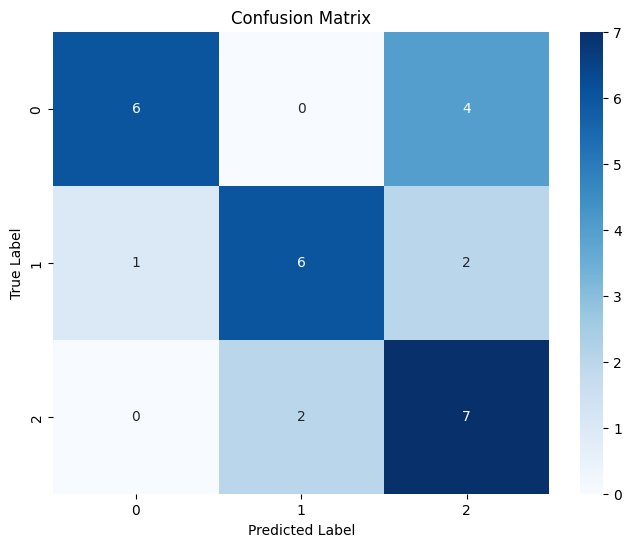

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'results_df' is your DataFrame with 'true_label' and 'predicted_label' columns
cm = confusion_matrix(results_df['true_label'], results_df['predicted_label'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from IPython.display import display, HTML

def display_results(df):
  html = """
  <style>
    table {
      border-collapse: collapse;
      width: 100%;
    }

    th, td {
      border: 1px solid black;
      padding: 8px;
      text-align: left;
    }

    th {
      background-color: #f2f2f2;
    }

    .text-column {
      width: 60%;
      word-wrap: break-word;
    }

    .narrow-column {
      width: 10%;
    }
  </style>
  <table>
    <thead>
      <tr>
        <th class="text-column">Text</th>
        <th>True Label</th>
        <th class="narrow-column">Predicted Label</th>
      </tr>
    </thead>
    <tbody>
  """

  for index, row in df.iterrows():
    html += f"""
      <tr>
        <td class="text-column">{row['text']}</td>
        <td>{row['true_label']}</td>
        <td class="narrow-column">{row['predicted_label']}</td>
      </tr>
    """

  html += """
    </tbody>
  </table>
  """

  display(HTML(html))


display_results(results_df[:10])

Text,True Label,Predicted Label
"Produkt posiada wszystkie wcięcia które powinien posiadać, lecz nie wszystkie kable da się podłączyć do lądowania (dolną część ramki przy gnieździe do ładowania trzeba nadpiłować). Poza tym ramka godna polecenia. Nie odpina się, spadł telefon mi nie raz i nadal żyje (nie korzystam ze szkła hartowanego). Lepsze rozwiązanie niż z podobnymi ramkami przykręcanymi na śrubki które wiecznie się odkręcają.",1,1
"Po niecałym dniu użytkowania szkło zaczęło się kruszyć i pękać, mimo że telefon był w obudowie i tak na prawdę nie uległ żadnemu upadkowi, ani niczemu co mogło wpłynąć na jego uszkodzenie. Mam też wrażenie, że nieco wpływa na jakość przedniego aparatu, ponieważ czasami obraz jest zamglony. Dopasowanie jest jednak bardzo dobre i sam klej dobrze trzyma.",0,0
"ciężko podważyć ich oryginalność, na co dostałem zapewnienie, bo wyglądają identycznie jak te dołączone do Samsunga S8 za 2500zł, które miałem okazję testować od znajomego (dlatego się połasiłem) Niemniej grają o wiele słabiej. Mają zdecydowanie mniej dołu, są cichsze, dźwięk jest mniej nasycony. Reasumując sugeruję testować je na miejscu i wtedy podejmować decyzję w celu uniknięcia rozczarowania. pozdrawiam.",0,0
"Moja stara N72 padła po 8 latach użytkowania. Nikt nie chciał podjąć się naprawy. Kupiłem ten sam model ze względu na bezawaryjność, przyciski (sic!) i sentyment. Choć również jestem użytkownikiem smartfona, to preferuję telefony z klawiaturą, zwłaszcza, gdy korzystam z urządzenia na mrozie czy deszczu. Nokia E72 nigdy mnie nie zawiodła.",1,1
"Sprzedającego ten produkt omijać z daleka. Sprzęt nie zgodny z tym co jest wystawione na aukcji,czyli starszy model. Widoczne były ślady użytkowania. Nie podłączyłem tych słuchawek bo nie był to ten model co widniał na aukcji. Reklamacja i zwrot odbyła się bez problemów z jedną małą rzeczą.. Nie mogłem odesłać w pakiecie Smart.",0,2
"Urządzenie kupione w celu użytkowania, jako budzik doskonale widoczny w nocy. Spełnia swą rolę doskonale, jednakże ekran dotykowy oraz menu ustawień jest niskiej jakości. To samo dotyczy wyboru wyświetlania czasu - po prostu nie ma go. Zdaję sobie sprawę, że jest to urządzenie mające służyć zupełnie innym celom, ale lepszą decyzją byłby tablet...",1,2
"Bardzo kiepskie wykonanie nie polecam zakupu. Klej naniesiony nie trzyma, dotyk źle wykrojony nie przylega do ramki w rogach, otwór na przycisk home zbyt wielki w konsekwencji przycisk lata na boki, trzeba się zaopatrzyć w klej B-7000, szkło nie dolane z wadą na środku w konsekwencji wielki bombel i o wiele za wąski od razu poszedł do kosza",0,0
"spełnia swoje zadanie, ale poprzedni model który miałem miał metalowy spód a tu plastik, nie otwiera się bezszelestnie tylko na sucho trochę szoruje (przydałoby się jakieś smarowanie), wydaje sygnał dźwiękowy otwierając się z kilko sek. opóźnieniem, to też w porównaniu do mojej oryginalnej z laptopa trochę dziwne, dioda świeci na żółto, a w starej miałem na pomarańczowo",1,0
Kamera działa ok ale radio to porażka. Guziki na przodzie to atrapa. Gdyby mi gdzieś pokrętło nie wyleciało bo nawet nie było przyklejone to bym odesłał. Gubi dźwięk i raz gra raz nie. Nawet żeby ściszyć to trzeba sie rozkojarzyć bo pokrętło na panelu nie działa. Nie tracie nerwów na te chińskie badziewia. Lepiej dołożyć i mieć spokój.,0,0
"Do Bosch SMV53L10EU pasuje IDEALNIE - wpasowuje się w nowe miejsce (które jest przygotowane w zmywarce), więc jeśli po drodze coś się połamało w gnieździe to bez obaw - wchodzi idealnie. Zastosowano łączenie bardziej trwałe niż w oryginalnej zmywarce. Wszystko na koniec trzeba delikatnie potraktować młotkiem, żeby schowało się pod osłonkę - każdy sobie z tym poradzi ;-)",2,1
